# Main document

### Initialization 

In [1]:
import pypsa
import pandas as pd
from BaseNetwork import BuildBaseNetwork
from silent_optimize import silent_optimize
import matplotlib.pyplot as plt
import numpy as np

# Task A

In [2]:
# Basemodel with one node for DK and four types of electricity generators
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
        }

# run simuation using weather data for 2017, projected prices in 2030 and the demand from 2019 
# NB: 2019 demand data is scaled to 2030 demand projections
BaseNetwork = BuildBaseNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)
silent_optimize(BaseNetwork.network)

Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 29.81it/s]


In [3]:
print(BaseNetwork.network.generators.p_nom_opt)

Generator
OCGT DK        8218.345380
solar DK        993.960115
offwind DK        0.000000
onwind DK     10696.528169
Name: p_nom_opt, dtype: float64


Year 2030 is greater than 2017, using data from last available year.


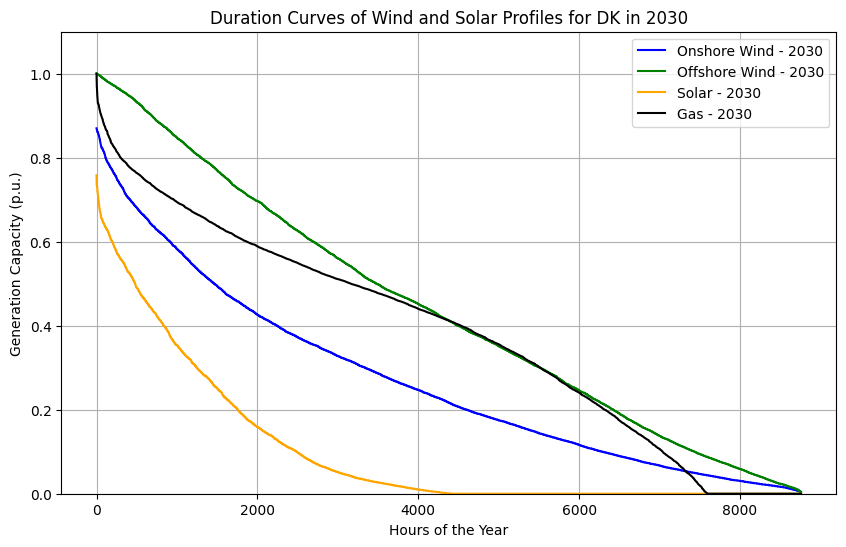

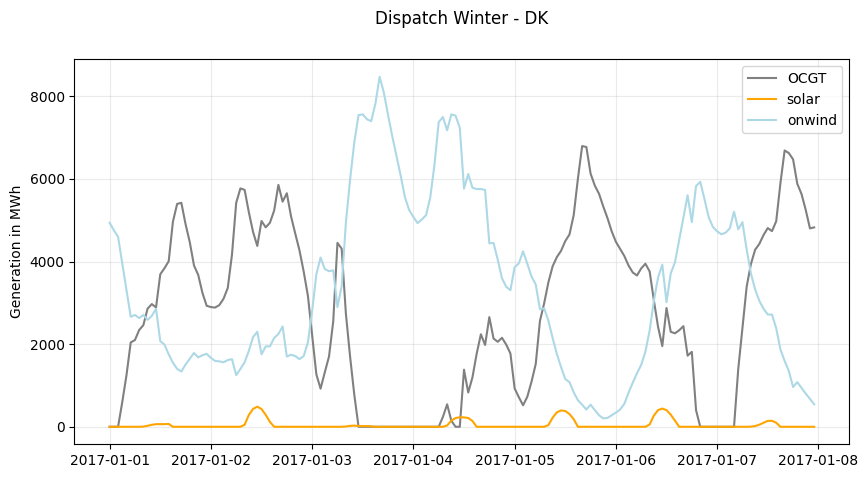

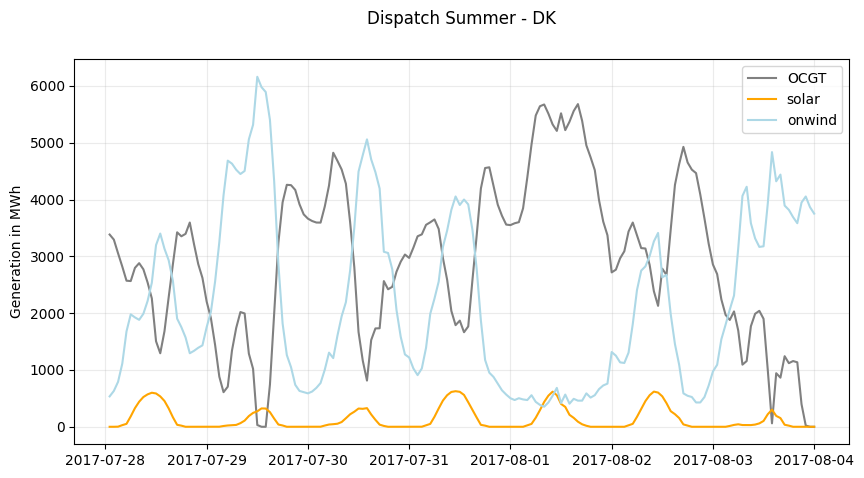

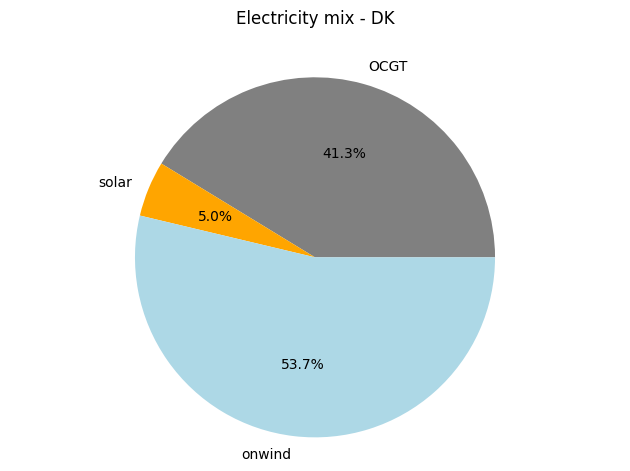

In [5]:
from Plot_scripts.PlotDispatch import PlotDispatch
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix
from Plot_scripts.DurationCurve import DurationCurve

installed_capacity = BaseNetwork.network.generators.p_nom_opt.filter(like='OCGT', axis=0).sum()
ocgt_results = BaseNetwork.network.generators_t.p.filter(like='OCGT', axis=1).sum(axis=1) / installed_capacity
ocgt_results_sorted = ocgt_results.sort_values(ascending=False).reset_index(drop=True)

DurationCurve(gas_data= ocgt_results_sorted, save_fig=True)
PlotDispatch(BaseNetwork, save_plots=True)
AnnualElectricityMix(BaseNetwork, save_plots=True)


# Task B

Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 23.39it/s]


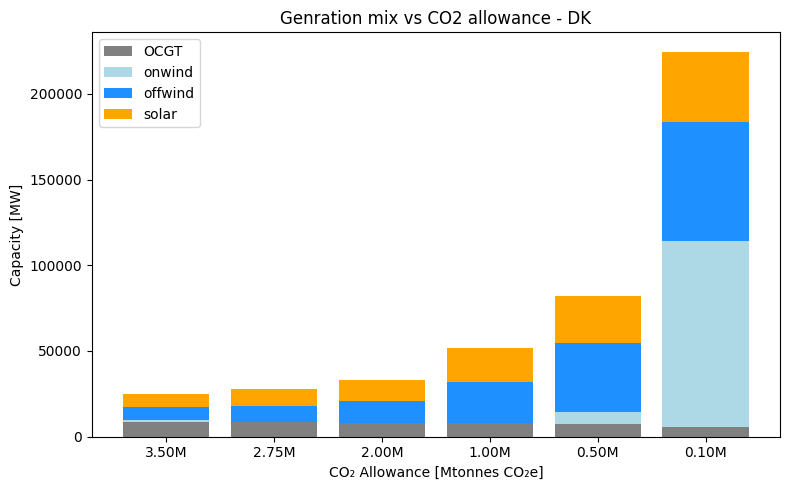

In [6]:
CO2_limits = [3_500_000, 2_750_000, 2_000_000, 1_000_000, 500_000, 100_000]

network_CO2 = {CO2_limit: None for CO2_limit in CO2_limits}

generator_opt = {
    key: {
        'OCGT': [],
        'CCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

CO2_price = []
objectives = []

for CO2_limit in CO2_limits:
    # Initialize the base network
    NetworkCO2_Constraint = BuildBaseNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)

    #Add CO2 constraint to the network
    NetworkCO2_Constraint.network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=CO2_limit)

    # Solve the network with the CO2 constraint
    silent_optimize(NetworkCO2_Constraint.network)

    network_CO2[CO2_limit] = NetworkCO2_Constraint.network

    # Extract the results
    CO2_price.append(-NetworkCO2_Constraint.network.global_constraints.mu['CO2Limit'])
    objectives.append(NetworkCO2_Constraint.network.objective)
    generators = NetworkCO2_Constraint.network.generators.p_nom_opt.keys()
    for region in NetworkCO2_Constraint.regions:
        for generator in generators:
            if generator.split(' ')[1] == region:
                generator_opt[region][generator.split(' ')[0]].append(NetworkCO2_Constraint.network.generators.p_nom_opt[generator].sum())

colors_tab = NetworkCO2_Constraint.colors

x = np.arange(len(CO2_limits))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech, color=colors_tab[tech])
            bottom += np.array(values)

    plt.xticks(x, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
    plt.title(f"Genration mix vs CO2 allowance - {country}")
    plt.xlabel("CO₂ Allowance [Mtonnes CO₂e]")
    plt.ylabel("Capacity [MW]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./Plots/Task_B_CO2_allowence_{country}_ny.png", dpi=300)
    plt.show()

Peak price day: 2017-01-21


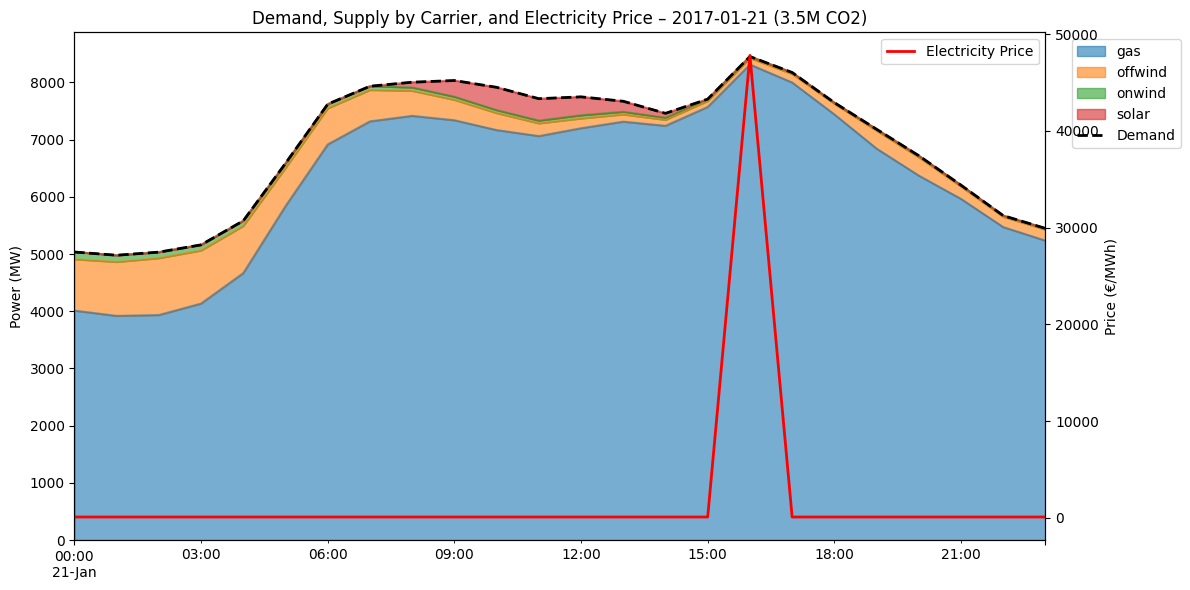

In [7]:
def plot_peak_day_supply_demand(network, title_suffix="", day=None):
    """
    Plots demand, supply by carrier, and average electricity price
    for the day with the highest average electricity price.

    Parameters:
        network: PyPSA network (already optimized)
        title_suffix: Optional string to add to the plot title
    """
    # 1. Find the peak price day
    avg_prices = network.buses_t.marginal_price.mean(axis=1)
    if day is None:
        peak_day = avg_prices.idxmax().strftime("%Y-%m-%d")
        ts_day = pd.date_range(f"{peak_day} 00:00", f"{peak_day} 23:00", freq="h")
    else:
        peak_day = day
        ts_day = pd.date_range(f"{peak_day} 00:00", f"{peak_day} 23:00", freq="h")
    
    print(f"Peak price day: {peak_day}")

    # 2. Demand
    demand = network.loads_t.p.loc[ts_day].sum(axis=1)

    # 3. Generation by carrier
    generation = network.generators_t.p.loc[ts_day]
    carrier_map = network.generators.carrier
    generation_by_carrier = generation.T.groupby(carrier_map).sum().T

    # 4. Electricity price (average across buses)
    price = network.buses_t.marginal_price.loc[ts_day].mean(axis=1)

    # 5. Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Stack plot of generation
    generation_by_carrier.plot.area(ax=ax1, stacked=True, alpha=0.6)
    
    # Demand line
    demand.plot(ax=ax1, label="Demand", color="black", linestyle="--", linewidth=2)

    ax1.set_ylabel("Power (MW)")
    ax1.set_title(f"Demand, Supply by Carrier, and Electricity Price – {peak_day} {title_suffix}")
    ax1.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    # Add price on secondary axis
    ax2 = ax1.twinx()
    price.plot(ax=ax2, color="red", label="Electricity Price", linewidth=2)
    ax2.set_ylabel("Price (€/MWh)")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

# Select the day with the spike
n_4 = network_CO2[3_500_000] 

plot_peak_day_supply_demand(n_4, title_suffix="(3.5M CO2)")

# Task C

In [8]:
# Basemodel with DK
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
                }

years = [2013, 2014, 2015, 2016, 2017] #used to investigate different weather years

network_year = {year: None for year in years}

generator_opt_year = {
    key: {
        'OCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

objectives_year = []

for year in years:
    # Initialize the base network
    Network_Yearly = BuildBaseNetwork(year = year, cost_year = 2030, setup = setup, demand_year=2019)

    # Solve the network for the specific year
    silent_optimize(Network_Yearly.network)

    network_year[year] = Network_Yearly.network

    # Extract the results
    objectives_year.append(Network_Yearly.network.objective)
    generators_year = Network_Yearly.network.generators.p_nom_opt.keys()
    for region in Network_Yearly.regions:
        for generator in generators_year:
            if generator.split(' ')[1] == region:
                generator_opt_year[region][generator.split(' ')[0]].append(Network_Yearly.network.generators.p_nom_opt[generator].sum())

Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 23.63it/s]


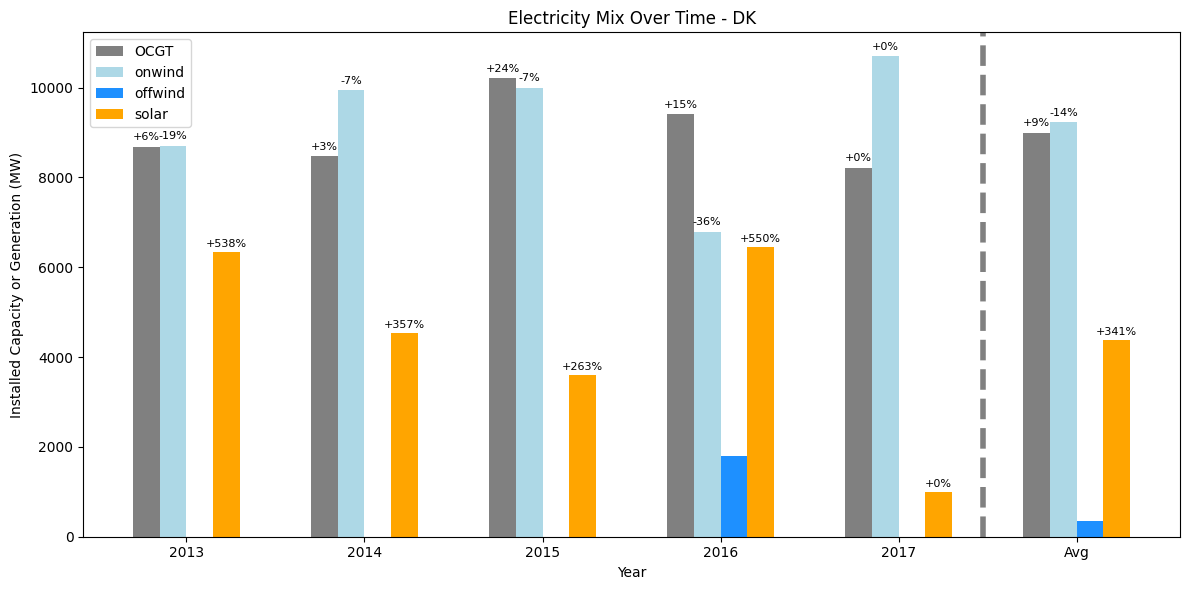

In [9]:
def plot_generation_mix_with_percentage_labels(years, generator_opt_year, base_year=2017):
    x = np.arange(len(years) + 1)  # One extra slot for 'Average'
    bar_width = 0.15

    for country, techs in generator_opt_year.items():
        plt.figure(figsize=(12, 6))

        for i, tech in enumerate(techs.keys()):
            values = techs.get(tech, [])
            if not values:
                continue

            # Get base value for normalization
            try:
                base_index = years.index(base_year)
                base_value = values[base_index]
            except (ValueError, IndexError):
                print(f"Warning: Base year {base_year} not found or no data for tech {tech}. Skipping label.")
                base_value = 0

            avg = np.mean(values)
            values_with_avg = values + [avg]

            bar_positions = x + i * bar_width
            bars = plt.bar(bar_positions, values_with_avg, width=bar_width, label=tech, color=colors_tab[tech])

            # Add percentage labels relative to base year
            for j, (bar, val) in enumerate(zip(bars, values_with_avg)):
                if base_value != 0:
                    pct_change = ((val - base_value) / base_value) * 100
                    label = f"{pct_change:+.0f}%"
                else:
                    label = ""  # Avoid division by zero

                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + max(values_with_avg) * 0.01,
                    label,
                    ha='center',
                    va='bottom',
                    fontsize=8
                )
        # Add vertical dotted line before 'Avg'
        split_position = x[-2] + bar_width * len(techs) + 0.1  # End of last year group

        plt.axvline(x=split_position , color='gray', linestyle='--', linewidth=4)

        xtick_labels = years + ['Avg']
        plt.xticks(x + bar_width * (len(techs.keys()) - 1) / 2, xtick_labels)

        plt.title(f"Electricity Mix Over Time - {country}")
        plt.xlabel("Year")
        plt.ylabel("Installed Capacity or Generation (MW)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'./plots/sectionC.png', dpi=300, bbox_inches='tight')

        plt.show()
colors_tab = Network_Yearly.colors
plot_generation_mix_with_percentage_labels(years, generator_opt_year, base_year=2017)

# Task D

In [ ]:
from ExpandedNetwork import ExpandedNetwork
from Plot_scripts.DispatchSoC import PlotDispatchSoC
from silent_optimize import silent_optimize
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

year = 2017
cost_year = 2030
demand_year = 2019 # again the profile from 2019 will be used and scaled to 2030 values in DataGeneration
setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }}

Expanded_Network = ExpandedNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)
silent_optimize(Expanded_Network.network)

Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.41it/s]


In [11]:
print(Expanded_Network.network.stores.e_nom_opt)

Store
battery storage DK        1835.507795
H2 (l) storage tank DK       0.000000
Name: e_nom_opt, dtype: float64


In [ ]:
print(Expanded_Network.network.storage_units.p_nom_opt)

Series([], Name: p_nom_opt, dtype: float64)


c:\Users\jpspa\OneDrive - Danmarks Tekniske Universitet\master\4. semester\Integrated Energy Grids\ieg\Plot_scripts\DispatchSoC.py:60: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



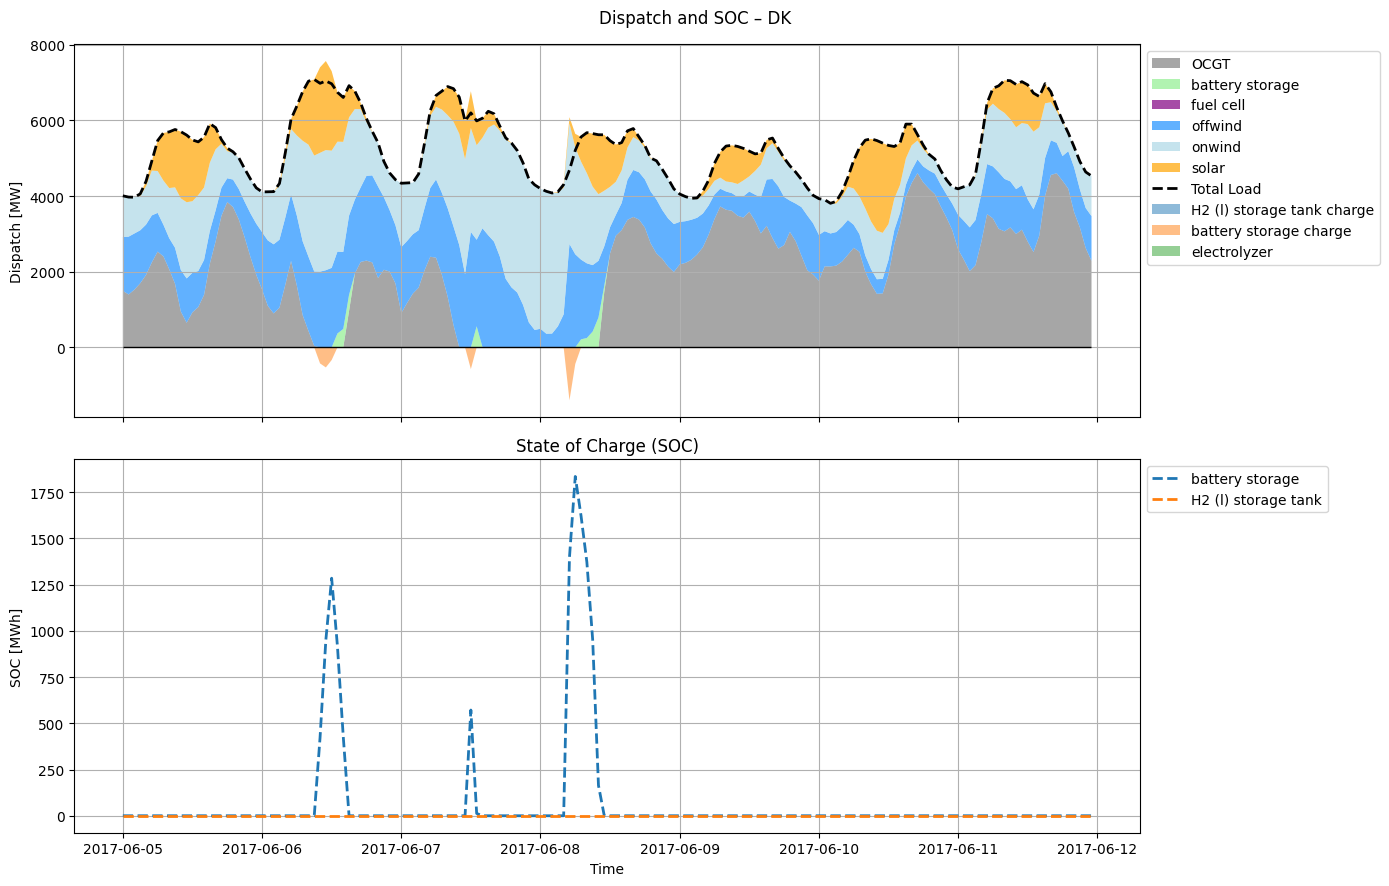

In [ ]:
PlotDispatchSoC(Expanded_Network, start="2017-06-05 00:00", end="2017-06-11 23:00", save_plots=True)

# Task E

Select one target for decarbonization (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your results.

In [ ]:
CO2_limits = [3_500_000, 2_750_000, 2_000_000, 1_000_000, 500_000, 100_000]

network_CO2 = {CO2_limit: None for CO2_limit in CO2_limits}

generator_opt = {
    key: {
        'OCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

storage_opt = {
    key: {
        'battery storage': [],
        'H2 (l) storage tank': [] }
    for key in setup.keys()}

CO2_price = []
objectives = []

for CO2_limit in CO2_limits:
    # Initialize the base network
    NetworkCO2_Constraint = ExpandedNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)

    #Add CO2 constraint to the network
    NetworkCO2_Constraint.network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=CO2_limit)

    # Solve the network with the CO2 constraint
    silent_optimize(NetworkCO2_Constraint.network)

    network_CO2[CO2_limit] = NetworkCO2_Constraint.network

    # Extract the results
    CO2_price.append(-NetworkCO2_Constraint.network.global_constraints.mu['CO2Limit'])
    objectives.append(NetworkCO2_Constraint.network.objective)
    generators = NetworkCO2_Constraint.network.generators.p_nom_opt.keys()
    for region in NetworkCO2_Constraint.regions:
        for generator in generators:
            if generator.split(' ')[1] == region:
                generator_opt[region][generator.split(' ')[0]].append(NetworkCO2_Constraint.network.generators.p_nom_opt[generator].sum())

    for region in NetworkCO2_Constraint.regions:
        for store in NetworkCO2_Constraint.network.stores.index:
            if store.endswith(region):
                store_type = store.replace(f" {region}", "")
                if store_type in storage_opt[region]:
                    storage_opt[region][store_type].append(NetworkCO2_Constraint.network.stores.e_nom_opt[store])

x = np.arange(len(CO2_limits))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
    plt.title(f"Electricity Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Capacity")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
for country, techs in storage_opt.items(): 
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
    plt.title(f"Storage Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Capacity")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
[val for val in CO2_price]

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(CO2_limits, [val * 7.45 for val in CO2_price], marker='o')
plt.xticks(CO2_limits, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
# Force axis limits update before hlines
plt.gca().relim()
plt.gca().autoscale_view()

# Get x-limits from the plot
xmin, xmax = plt.xlim()
plt.hlines(y=85.2, xmin=xmin, xmax=xmax, color='black', linestyle='--', label='CO₂ Price in 2025 (DKK)')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Task F 

In [ ]:
from Plot_scripts.DispatchSoCInternational import PlotInternationalDispatchSoC
from ExpandedNetwork import ExpandedNetwork
from silent_optimize import silent_optimize
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix


year = 2017
cost_year = 2030
demand_year = 2019,
setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            },
        'DE': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            },
        'NO': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }
            }

International_Network = ExpandedNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)
regions = list(International_Network.regions)

#Link between DK and DE
International_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[1]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 1000, # max capacity is 1000 MW
             p_min_pu=-1,
             capital_cost=International_Network.costs.at['HVAC overhead', "capital_cost"] * 10000,
             ) 

#Link between DK and NO
International_Network.network.add("Link",
             f'{regions[0]} - {regions[2]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[2]}",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             capital_cost=International_Network.costs.at['HVDC submarine', "capital_cost"] * 10000
             ) 

co2_limits = {
    'DK': 5_000_000,
    'DE': 20_000_000,
    'NO': 6_000_000
}

for region, limit in co2_limits.items():
    carrier = f"gas {region}"
    International_Network.network.add(
        "GlobalConstraint",
        f"CO2Limit {region}",
        carrier_attribute="co2_emissions",
        sense="<=",
        carrier=carrier,
        constant=limit
    )

silent_optimize(International_Network.network)
AnnualElectricityMix(International_Network)
PlotInternationalDispatchSoC(International_Network, start="2017-06-05 00:00", end="2017-06-11 23:00")

In [ ]:
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
from shapely.errors import ShapelyDeprecationWarning

gen = International_Network.network.generators_t.p.mean().groupby(
    International_Network.network.generators.bus
).sum()

# Safe reindex to include all buses
gen = gen.reindex(International_Network.network.buses.index).fillna(0)

plt.figure(figsize=(12, 8))  # Adjust size here

International_Network.network.plot(
    bus_sizes=gen / 5e4,
    margin=0.5,
    line_widths=1,
    link_widths=1,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
)
plt.show()


In [ ]:
print(International_Network.network.global_constraints.constant) # CO2 limit (constant in the constraint)
print(International_Network.network.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

# Task G

In [ ]:
from ExpandedHeatNetwork import ExpandedHeatNetwork
from silent_optimize import silent_optimize
from Plot_scripts.DispatchSoCHeatInternational import PlotInternationalDispatchSoCHeat
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            },
        'DE': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            },
        'NO': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            }
}

year = 2017
cost_year = 2030
demand_year = 2019,
Expanded_Heat_Network = ExpandedHeatNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)

regions = list(Expanded_Heat_Network.regions)

#Link between DK and DE
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[1]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 1000, # max capacity is 1000 MW
             p_min_pu=-1,
             capital_cost=Expanded_Heat_Network.costs.at['HVAC overhead', "capital_cost"] * 10000,
             ) 

#Link between DK and NO
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[2]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[2]}",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             capital_cost=Expanded_Heat_Network.costs.at['HVDC submarine', "capital_cost"] * 10000
             ) 

co2_limits = {
    'DK': 5_000_000,
    'DE': 30_000_000,
    'NO': 6_500_000
}

for region, limit in co2_limits.items():
    carrier = f"gas {region}"
    Expanded_Heat_Network.network.add(
        "GlobalConstraint",
        f"CO2Limit {region}",
        carrier_attribute="co2_emissions",
        sense="<=",
        carrier=carrier,
        constant=limit
    )

silent_optimize(Expanded_Heat_Network.network)

AnnualElectricityMix(Expanded_Heat_Network)

PlotInternationalDispatchSoCHeat(Expanded_Heat_Network, start="2017-01-05 00:00", end="2017-01-11 23:00")
PlotInternationalDispatchSoCHeat(Expanded_Heat_Network, start="2017-06-05 00:00", end="2017-06-11 23:00")

In [ ]:
PlotInternationalDispatchSoCHeat(Expanded_Heat_Network, start="2017-01-05 00:00", end="2017-01-11 23:00")

In [ ]:
Expanded_Heat_Network.network.links_t.p2

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(Expanded_Heat_Network.network.loads_t.p_set['heat load DE'], label = 'DE')
plt.plot(Expanded_Heat_Network.network.loads_t.p_set['heat load DK'], label = 'DK')
# plt.plot(Expanded_Heat_Network.network.loads_t.p_set['heat load NO'], label = 'NO')
plt.title("Heat Load Over Time")
plt.xlabel("Time")
plt.ylabel("Heat Load (MW)")
plt.legend()
plt.grid()
plt.show()



In [ ]:
from CostGeneration import CostGeneration

costs = CostGeneration(year = 2030).costs

costs

In [ ]:
from Plot_scripts.PlotDispatch import PlotDispatch
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix
from Plot_scripts.DurationCurve import DurationCurve
from BaseNetwork import BuildBaseNetwork
from silent_optimize import silent_optimize

# Basemodel with DK and DE
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
        # 'DE': 
        #         {'OCGT': True,
        #         'solar': True,
        #         'offwind': True,
        #         'onwind': True,}
                # 'CCGT': True},
                }

BaseNetwork = BuildBaseNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)
silent_optimize(BaseNetwork.network)

#DurationCurve(years = years, region = region)
installed_capacity = BaseNetwork.network.generators.p_nom_opt.filter(like='OCGT', axis=0).sum()
ocgt_results = BaseNetwork.network.generators_t.p.filter(like='OCGT', axis=1).sum(axis=1) / installed_capacity
ocgt_results_sorted = ocgt_results.sort_values(ascending=False).reset_index(drop=True)

years = [2017]

# DurationCurve(years = years, region = region, gas_data= ocgt_results_sorted)

PlotDispatch(BaseNetwork)
AnnualElectricityMix(BaseNetwork)



In [ ]:
AnnualElectricityMix(BaseNetwork)

In [ ]:
from ExpandedNetwork import ExpandedNetwork
from Plot_scripts.DispatchSoC import PlotDispatchSoC
from silent_optimize import silent_optimize
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

year = 2017
cost_year = 2030
demand_year = 2019,
setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }}

Expanded_Network = ExpandedNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)
silent_optimize(Expanded_Network.network)

# AnnualElectricityMix(Expanded_Network)
PlotDispatchSoC(Expanded_Network, start="2017-06-05 00:00", end="2017-06-11 23:00")

In [ ]:
from Plot_scripts.DispatchSoCInternational import PlotInternationalDispatchSoC
from ExpandedNetwork import ExpandedNetwork
from silent_optimize import silent_optimize
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix


year = 2017
cost_year = 2030
demand_year = 2019,
setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            },
        'DE': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            },
        'NO': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }
            }

International_Network = ExpandedNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)
regions = list(International_Network.regions)

#Link between DK and DE
International_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[1]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 1000, # max capacity is 1000 MW
             p_min_pu=-1,
             capital_cost=International_Network.costs.at['HVAC overhead', "capital_cost"] * 10000,
             ) 

#Link between DK and NO
International_Network.network.add("Link",
             f'{regions[0]} - {regions[2]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[2]}",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             capital_cost=International_Network.costs.at['HVDC submarine', "capital_cost"] * 10000
             ) 

# co2_limits = {
#     'DK': 5_000_000,
#     'DE': 20_000_000,
#     'NO': 6_000_000
# }

# for region, limit in co2_limits.items():
#     carrier = f"gas {region}"
#     International_Network.network.add(
#         "GlobalConstraint",
#         f"CO2Limit {region}",
#         carrier_attribute="co2_emissions",
#         sense="<=",
#         carrier=carrier,
#         constant=limit
#     )

silent_optimize(International_Network.network)
AnnualElectricityMix(International_Network)
PlotInternationalDispatchSoC(International_Network, start="2017-06-05 00:00", end="2017-06-11 23:00")